# EE 559 Project
Ronald Huang & Henry Chen

### Import Libraries

In [ ]:
# Import packages
import math
import numpy as np
import pandas as pd
import seaborn as sns


# For Computing Priors
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import normalize



# For Model Selection
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures





import matplotlib.pyplot as plt


# For plotting ROC and Precision Recall curves
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


# For OS agnostic path handling
from os import path


### Data Import

In [ ]:
#Read in data
data_path = 'data/FLIR_groups1and2_train.csv'

read_data = pd.read_csv(data_path, skiprows = 2)
training_data_set = read_data.iloc[:, 2:]

#Seperate by Rounds
round_1 = training_data_set.iloc[:, :27]
round_2 = training_data_set.iloc[:, 28:55]
round_3 = training_data_set.iloc[:, 56:83]
round_4 = training_data_set.iloc[:, 84:111]

In [ ]:
#seperate extra features
extra_features = training_data_set[['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance']]
target = training_data_set['aveOralM']


In [ ]:
# One-Hot-Encoding
extra_features_copy = extra_features.copy()
# extra_features = pd.get_dummies(extra_features, columns=['Gender', 'Age', 'Ethnicity'])
extra_features = pd.get_dummies(extra_features_copy, columns=['Gender', 'Age', 'Ethnicity'])

extra_features_copy = extra_features


In [ ]:
# # Label Encoding 
# extra_features_copy = extra_features.copy()

# label_encoder = LabelEncoder()

# extra_features_copy['Gender_encoded'] = label_encoder.fit_transform(extra_features_copy['Gender'])
# extra_features_copy['Age_encoded'] = label_encoder.fit_transform(extra_features_copy['Age'])
# extra_features_copy['Ethnicity_encoded'] = label_encoder.fit_transform(extra_features_copy['Ethnicity'])

# extra_features_copy = extra_features_copy.drop(['Gender','Age','Ethnicity'], axis=1)

# # Display the encoded DataFrame
# extra_features_copy

In [ ]:
#Function to find empty rows 
def find_empty(round):
    empty_rows = []
    
    for i, row in round.iterrows():
        if row.isnull().all() or row.isna().any().any():
            empty_rows.append(i)
            
    return empty_rows
    
#find empty rows in each round
round_1_empty_rows = find_empty(round_1)
round_2_empty_rows = find_empty(round_2)
round_3_empty_rows = find_empty(round_3)
round_4_empty_rows = find_empty(round_4)

In [ ]:
#Compute the means of every feature
round_1_means = (round_1.mean()).values  #dtype is float64
round_2_means = (round_2.mean()).values
round_3_means = (round_3.mean()).values
round_4_means = (round_4.mean()).values

In [ ]:
#Function to insert means into missing rows 
def insert_mean(round_num, empty_rows, mean):
    rounds_final = round_num
    
    for i in empty_rows:
        rounds_final.loc[i] = mean

    return rounds_final  
    
#insert mean array into each empty row
final_round_1 = insert_mean(round_1, round_1_empty_rows, round_1_means)
final_round_2 = insert_mean(round_2, round_2_empty_rows, round_2_means)
final_round_3 = insert_mean(round_3, round_3_empty_rows, round_3_means)
final_round_4 = insert_mean(round_4, round_4_empty_rows, round_4_means)

In [ ]:
#check if there are any empty rows after inserting
test_empty_1 = find_empty(final_round_1)
print(test_empty_1)
test_empty_2 = find_empty(final_round_2)
print(test_empty_2)
test_empty_3 = find_empty(final_round_3)
print(test_empty_3)
test_empty_4 = find_empty(final_round_4)
print(test_empty_4)

# test_empty_extra = find_empty(extra_features)
# print(test_empty_extra)

[]
[]
[]
[]


In [ ]:
#compute final dataset with means from the 4 rounds (NO extra features yet)
final_dataset_means = pd.DataFrame()

for i in range(final_round_1.iloc[0, :].size):
    avg_values = (final_round_1.iloc[:, i] + final_round_2.iloc[:, i] + final_round_3.iloc[:, i] + final_round_4.iloc[:, i]) / 4
    
    final_dataset_means = pd.concat([final_dataset_means, avg_values], axis = 1)

In [ ]:
final_dataset_means_stand = (final_dataset_means - final_dataset_means.mean()) / final_dataset_means.std()


In [ ]:
col_names = ['T_offset_1','Max1R13_1','Max1L13_1','aveAllR13_1','aveAllL13_1','T_RC_1','T_RC_Dry_1','T_RC_Wet_1','T_RC_Max_1','T_LC_1','T_LC_Dry_1','T_LC_Wet_1','T_LC_Max_1','RCC_1','LCC_1','canthiMax_1','canthi4Max_1','T_FHCC_1','T_FHRC_1','T_FHLC_1','T_FHBC_1','T_FHTC_1','T_FH_Max_1','T_FHC_Max_1','T_Max_1','T_OR_1','T_OR_Max_1']

final_dataset_means_stand.columns = col_names

raw_dataset_nolabel = pd.concat([final_dataset_means_stand, extra_features_copy], axis=1)
raw_dataset = pd.concat([raw_dataset_nolabel, target], axis=1)
print(raw_dataset.shape)



(710, 47)


In [ ]:
#split data into test and validation sets
X_training_data = raw_dataset.iloc[:, :-1]  # Features
y_training_data = raw_dataset.iloc[:, -1]   # Labels

x_train, x_val, y_train, y_val = train_test_split(X_training_data, y_training_data, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(568, 46)
(142, 46)
(568,)
(142,)


In [ ]:
#Linear Regression function
def LinReg(train_data, train_label, val_data, val_label):
    '''
    Function trains the model based off training data and returns prediction labels
    '''
    model = LinearRegression()
    model.fit(train_data, train_label)
    prediction_label = model.predict(val_data)

    return prediction_label

In [ ]:
#Compute mse, root mse, mae, accuracy given validation label and prediction labels from model
def compute_metrics(val_label, prediction_label):

    mse = mean_squared_error(val_label, prediction_label)
    r_mse = np.sqrt(mse)
    mae = mean_absolute_error(val_label, prediction_label)
        
    return mse, r_mse, mae

In [ ]:
model_test_prediction_raw = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_raw, r_mse_raw, mae_raw = compute_metrics(y_val, model_test_prediction_raw) # calculate metrics

print("Mean Squared Error for all features: ", mse_raw)
print("Root Mean Squared Error for all features: ", r_mse_raw)
print("Mean Absolute Error for all features: ", mae_raw)

Mean Squared Error for all features:  0.07320517203262436
Root Mean Squared Error for all features:  0.2705645431918683
Mean Absolute Error for all features:  0.21399553663946502


#### Polynomial Feature Mapping 

In [ ]:
poly_map = PolynomialFeatures(degree=2, include_bias=True)

#perform polynomial feature expansion
#this data is expanded WITHOUT one hot encoded features and labels
data_expanded = poly_map.fit_transform(final_dataset_means_stand)
data_expanded_df = pd.DataFrame(data_expanded)
print(data_expanded_df.shape)

(710, 406)


#### PCA on Mapped Features (without extra features)

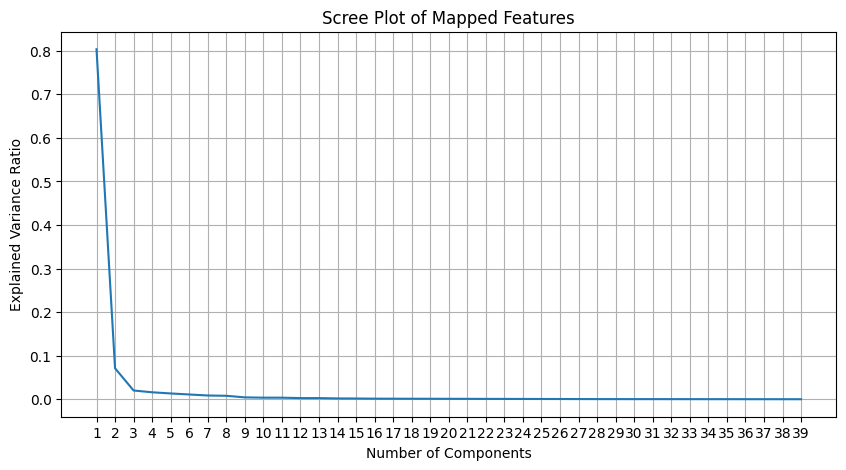

In [ ]:
# Create Scree Plot to determine how many features to include

num_components = np.arange(1, 40)
pca = PCA(n_components=40)  
pca.fit(data_expanded_df)

plt.figure(figsize=(10, 5))  
explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(num_components, explained_variance_ratio[:39], linestyle='-')  
plt.title('Scree Plot of Mapped Features')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(num_components)
plt.grid(True)
plt.show() 

In [ ]:
pca_mapped_data = PCA(n_components=30)
pca_transform_mapped = pca_mapped_data.fit_transform(data_expanded_df)
print(pca_transform_mapped.shape)
pca_transform_mapped_df = pd.DataFrame(pca_transform_mapped)
pca_transform_mapped_df

(710, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,3.830514,14.270419,0.003128,-1.422268,-2.729382,0.225069,2.418371,4.592684,-2.174745,-1.287513,...,0.291596,-1.472099,-1.012345,0.457556,2.159840,0.695003,-0.691661,1.108234,1.186535,1.305416
1,30.933947,-8.392663,-4.442625,2.628608,-0.319029,-6.079031,2.941502,8.778281,3.492139,1.559614,...,-1.739626,0.534422,-0.625699,1.185405,-0.320872,1.126819,-0.298556,-1.457080,0.684321,-0.080492
2,-14.599957,-1.316452,0.963888,0.073053,0.364731,0.894786,-0.876007,0.369229,-0.324800,-0.259140,...,-0.405863,-0.816480,-0.078277,-0.041509,-0.356444,0.156452,0.187199,0.339604,0.089362,0.033399
3,-12.729386,-2.973832,2.797423,1.903426,-2.446486,-1.805790,-0.082870,0.081780,-0.950677,-0.461100,...,2.385734,0.626685,-1.242361,0.645085,0.901287,0.517469,1.402008,-1.054281,0.554427,1.298772
4,-14.569603,-1.228532,0.792210,-0.029741,0.473702,0.876217,-0.717604,0.254400,-0.382208,-0.373084,...,-0.319184,0.037356,-0.656258,-0.149854,0.044265,0.743327,0.431784,0.254443,-0.068943,-0.345362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,-14.578086,-1.649821,0.790539,0.253667,0.265467,0.655759,-0.730696,0.659763,-0.237363,-0.224784,...,-0.847574,0.038941,-0.443321,0.137927,-0.011124,0.332613,-0.023766,-0.026408,-0.146454,-0.154597
706,-13.099851,-0.690384,2.436313,0.045810,0.757945,1.149938,-1.679344,-0.966392,-0.581605,-0.155076,...,-0.338705,0.144069,-0.191601,0.334135,-0.994800,0.281502,-1.034929,-0.772472,-0.090821,-0.123779
707,35.710775,-19.876890,1.428588,-0.075550,-6.995642,1.728172,2.059091,-7.918144,2.419013,0.416758,...,-1.679283,1.801956,-0.228473,0.708046,-0.118389,-4.122784,-0.151803,0.093866,-0.093996,0.331754
708,85.481464,-17.631432,-13.341872,-4.922693,5.457729,4.180399,2.166595,-2.501829,-1.925366,-2.326416,...,1.993008,-2.648739,-1.414839,2.732056,0.923053,-0.346370,-0.137993,0.199605,-0.469758,1.497062


In [ ]:
# Insert back in the original column names
# col_names = ['T_offset_1','Max1R13_1','Max1L13_1','aveAllR13_1','aveAllL13_1','T_RC_1','T_RC_Dry_1','T_RC_Wet_1','T_RC_Max_1','T_LC_1','T_LC_Dry_1','T_LC_Wet_1','T_LC_Max_1','RCC_1','LCC_1','canthiMax_1','canthi4Max_1','T_FHCC_1','T_FHRC_1','T_FHLC_1','T_FHBC_1','T_FHTC_1','T_FH_Max_1','T_FHC_Max_1','T_Max_1','T_OR_1','T_OR_Max_1']

# pca_transform_mapped_df.columns = col_names

# Add the extra features to the final means dataset to form the final dataset


final_dataset_nolabel = pd.concat([pca_transform_mapped_df, extra_features_copy], axis=1)
final_dataset = pd.concat([final_dataset_nolabel, target], axis=1)
print(final_dataset.shape)

# final_dataset has been feature mapped and PCAed

(710, 50)


In [ ]:
X_training_data_poly_pca = final_dataset.iloc[:, :-1]  # Features
y_training_data_poly_pca = final_dataset.iloc[:, -1]   # Labels

x_train_poly_pca, x_val_poly_pca, y_train_poly_pca, y_val_poly_pca = train_test_split(X_training_data_poly_pca, y_training_data_poly_pca, test_size=0.2, random_state=42)

print(x_train_poly_pca.shape)
print(x_val_poly_pca.shape)
print(y_train_poly_pca.shape)
print(y_val_poly_pca.shape)

(568, 49)
(142, 49)
(568,)
(142,)


In [ ]:
model_test_prediction_pp = LinReg(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca) # train linear regression model

mse_pp, r_mse_pp, mae_pp = compute_metrics(y_val_poly_pca, model_test_prediction_pp) # calculate metrics

print("Mean Squared Error for all features: ", mse_pp)
print("Root Mean Squared Error for all features: ", r_mse_pp)
print("Mean Absolute Error for all features: ", mae_pp)

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

### Data Transformation and Exploration

# To Do List
1. Train some regression model (Use linear regression (multi dimensional). not SVM because DOF is different compared to others (doesnt generalise well) ) off the whole data set as a baseline result so we can compare. Use cross validation - done
2. based off correlation matrix, remove features that are correlated, then test against a model with the rest of the features - TO DO
3. use backward sequential feature selection to remove x amount of features, see if it agrees with what we get for the first part - done
4. for the features, do PCA, test each PCA reduction against a model and see the best, we may not need to remove too many - done
5. potentially create some of our own features - TO DO
6. train one last time on remaining - i think leave this for the models
7. final visualisation on selected features - can leave this
8. Shuffle, split data into train and validation - TO DO

### Useful functions for data transformation and exploration

#### Splitting the entire dataset into Train and Validation

#### Intial Data Exploration

#### Exploratory Data Analysis

In [ ]:
###various plots about the data

##### Relation Between Attributes

<Axes: >

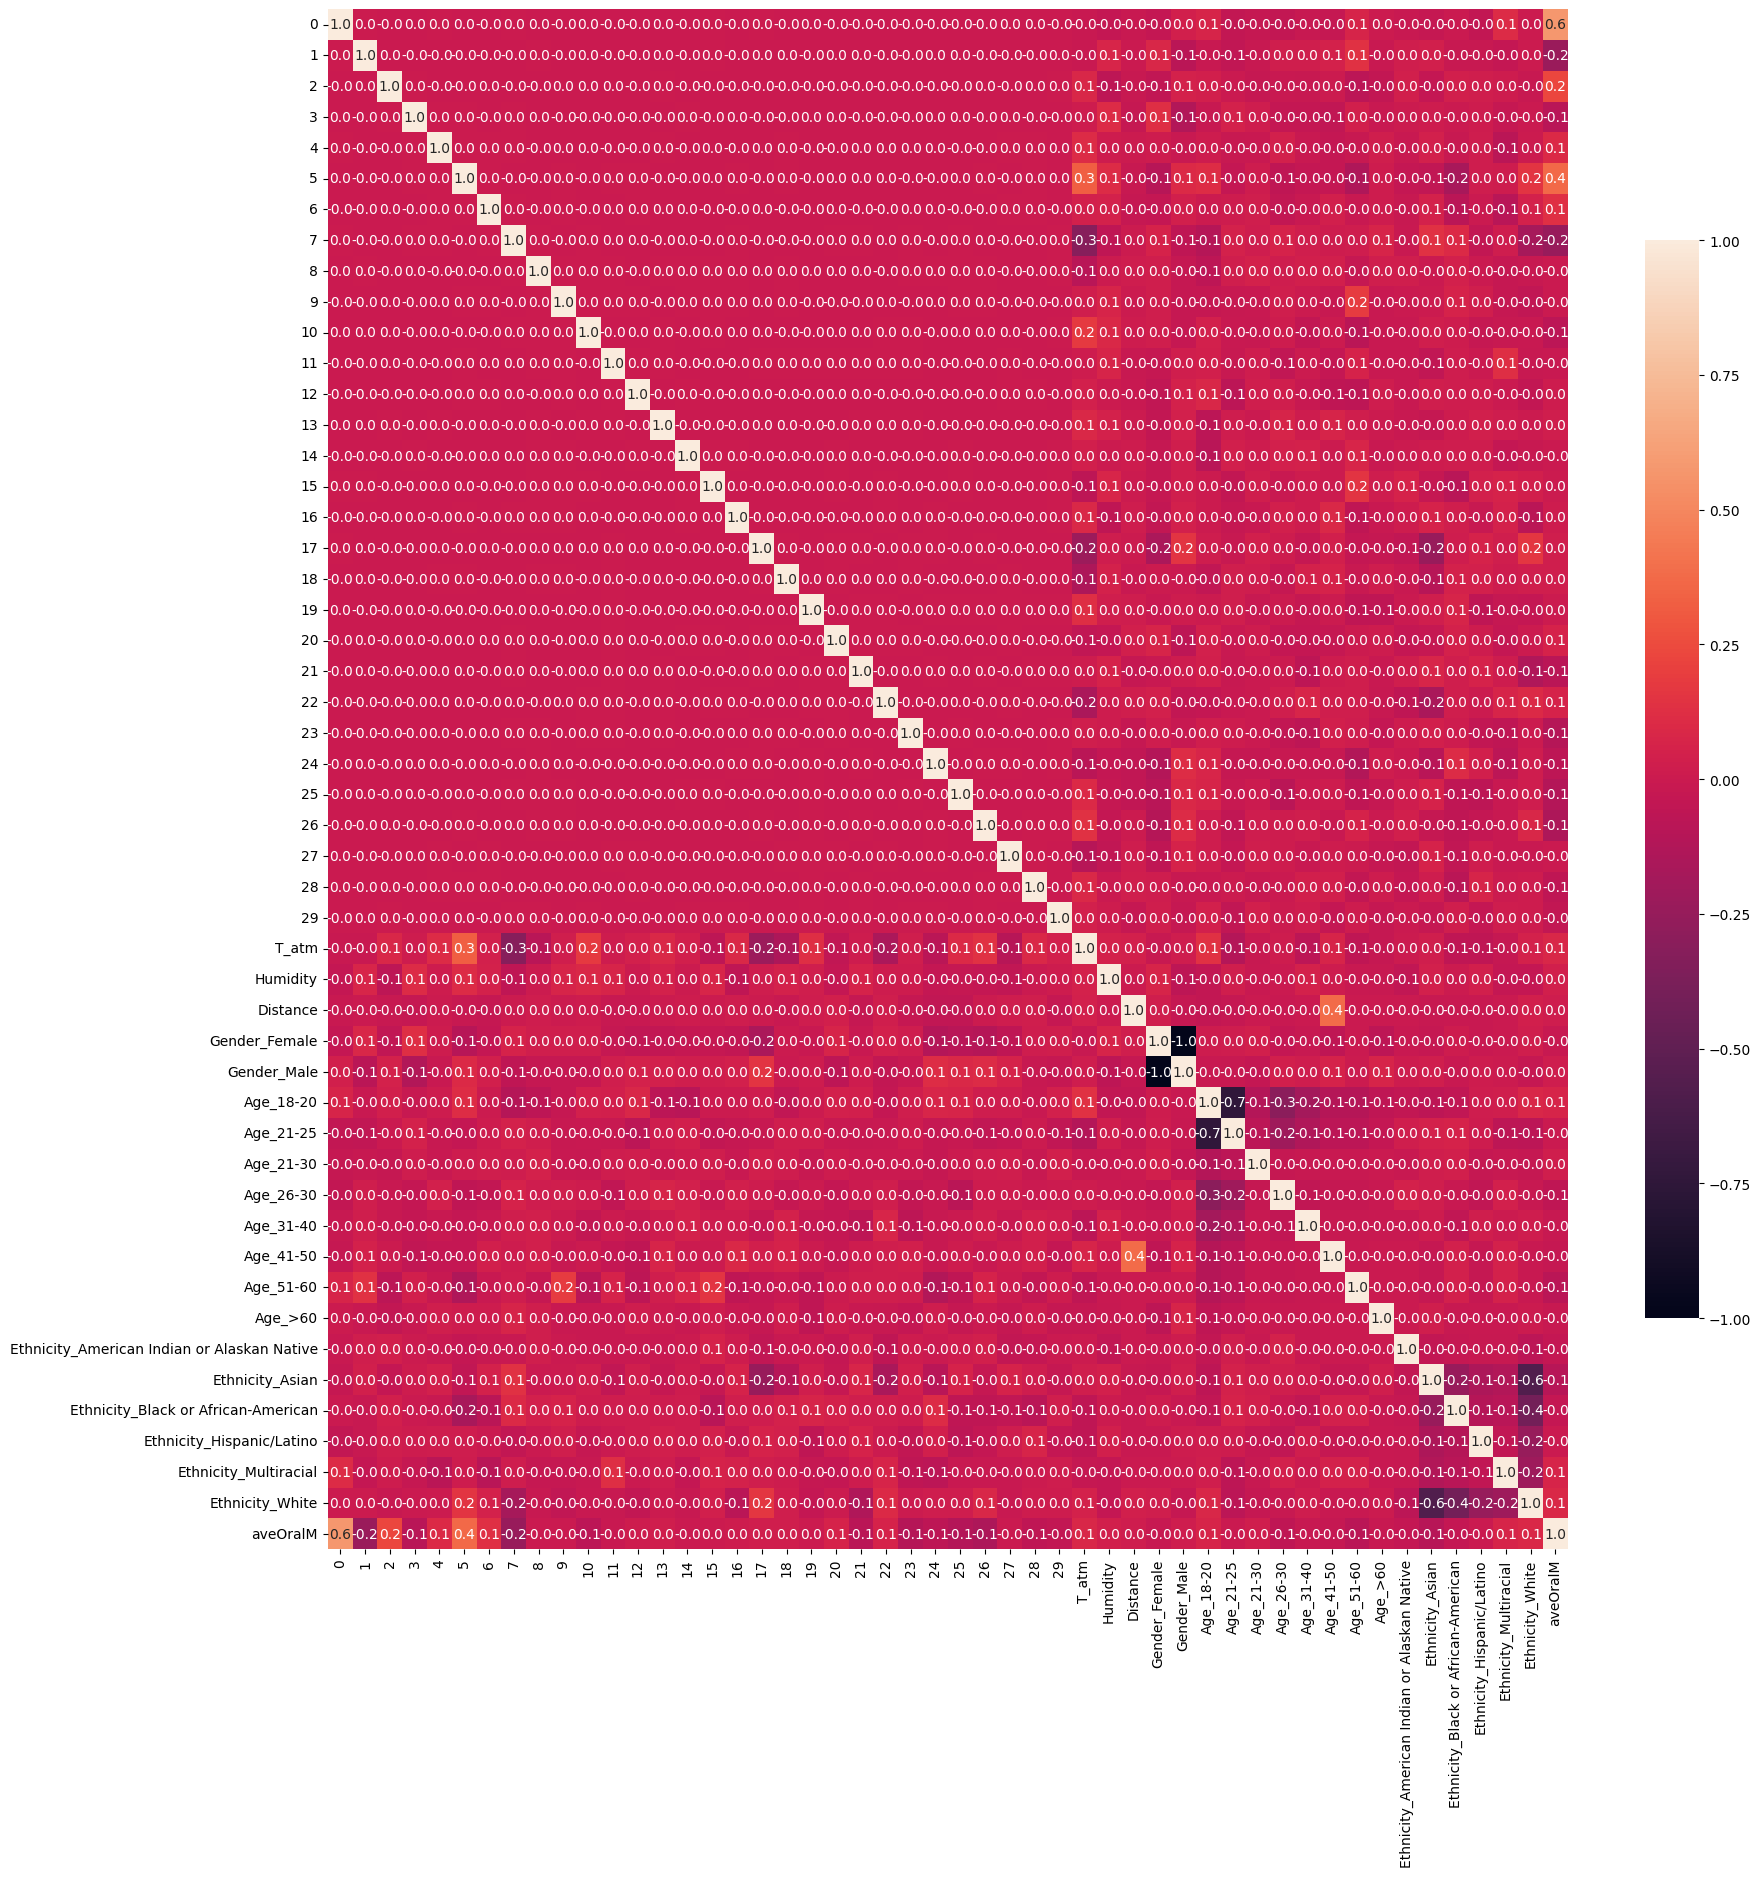

In [ ]:
# Correlation Matrix
plt.figure(figsize=(20, 20))
corrMatrix = final_dataset.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".1f", cbar_kws={"shrink": 0.7})

#### Training model on entire dataset

In [ ]:
model_test_prediction = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_all, r_mse_all, mae_all = compute_metrics(y_val, model_test_prediction) # calculate metrics

print("Mean Squared Error for all features: ", mse_all)
print("Root Mean Squared Error for all features: ", r_mse_all)
print("Mean Absolute Error for all features: ", mae_all)

Mean Squared Error for all features:  0.07320517203262436
Root Mean Squared Error for all features:  0.2705645431918683
Mean Absolute Error for all features:  0.21399553663946502


### Feature Reduction/Selection

In [ ]:
#Polynomial Feature Mapping



In [ ]:
#Feature Reduction using Sequential Backward Feature Selection
def seq_back_feat_select(model_reduce, n_features_to_select, direction):

    # Create a SequentialFeatureSelector object for backward selection
    sfs_backward = SequentialFeatureSelector(estimator=model_reduce, n_features_to_select=n_features_to_select, direction=direction)
    sfs_backward.fit(x_train, y_train)

    # Get the names of selected features
    selected_features_backward = x_train.columns[sfs_backward.support_]
    
    return selected_features_backward 

In [ ]:
# perform sequential feature selection for various number of features and validate the metrics each epoch
# num_feats = x_train.shape[1]
# feature_select_mse = []

# for i in range(num_feats-1,0,-1):
#     # print(f"Number of features: {i}")
#     selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'backward')

#     #extract features from x_train and x_val
#     x_train_select_features = x_train[selected_features_backward].copy()
#     x_val_select_features = x_val[selected_features_backward].copy()

#     model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
#     mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

#     feature_select_mse.append(mse_sf)

In [ ]:
# reversed_list = list(feature_select_mse)  # Make a copy of the list
# reversed_list.reverse()  # Reverse the copy of the list

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(reversed_list, marker='o', linestyle='-')
# plt.title('Sequential Feature Selection MSE')
# plt.xlabel('Number of Features')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# From plot we can see that we should take the top 26 features

In [ ]:
# perform sequential feature selection for various number of features and validate the metrics each epoch
# num_feats = x_train.shape[1]
# feature_select_mse = []

# for i in range(1, num_feats):
#     # print(f"Number of features: {i}")
#     selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'forward')

#     #extract features from x_train and x_val
#     x_train_select_features = x_train[selected_features_backward].copy()
#     x_val_select_features = x_val[selected_features_backward].copy()

#     model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
#     mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

#     feature_select_mse.append(mse_sf)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(feature_select_mse, marker='o', linestyle='-')
# plt.title('Sequential Feature Selection MSE')
# plt.xlabel('Number of Features')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# # From plot we can see that we should take the top 26 features

In [ ]:
# selected_features_backward = seq_back_feat_select(LinearRegression(), num_feats-1, 'forward')
# selected_features_backward

In [ ]:
# selected_features_backward = seq_back_feat_select(LinearRegression(), num_feats-3, 'forward')
# # selected_features_backward

In [ ]:
# perform sequential feature selection for various number of features and validate the metrics each epoch
# num_feats = x_train.shape[1]
# feature_select_mse = []

# for i in range(num_feats,1,-1):
#     # print(f"Number of features: {i}")
#     selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'backward')

#     #extract features from x_train and x_val
#     x_train_select_features = x_train[selected_features_backward].copy()
#     x_val_select_features = x_val[selected_features_backward].copy()

#     model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
#     mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

#     feature_select_mse.append(mse_sf)

In [ ]:
# reversed_list = list(feature_select_mse)  # Make a copy of the list
# reversed_list.reverse()  # Reverse the copy of the list

# reversed_list  # Print the reversed list

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(reversed_list, marker='o', linestyle='-')
# plt.title('Sequential Feature Selection MSE')
# plt.xlabel('Number of Features')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# From plot we can see that we should take the top 26 features

In [ ]:
# selected_features_backward = seq_back_feat_select(LinearRegression(), num_feats-3, 'forward')
# selected_features_backward

In [ ]:
# perform sequential feature selection for various number of features and validate the metrics each epoch
# num_feats = x_train.shape[1]
# feature_select_mse = []

# for i in range(1, num_feats):
#     # print(f"Number of features: {i}")
#     selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'forward')

#     #extract features from x_train and x_val
#     x_train_select_features = x_train[selected_features_backward].copy()
#     x_val_select_features = x_val[selected_features_backward].copy()

#     model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
#     mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

#     feature_select_mse.append(mse_sf)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(feature_select_mse, marker='o', linestyle='-')
# plt.title('Sequential Feature Selection MSE')
# plt.xlabel('Number of Features')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# From plot we can see that we should take the top 26 features

In [ ]:
# get features from best feature reduction: 26 features
# selected_features_backward = seq_back_feat_select(LinearRegression(), 26, 'backward')

# #extract features from x_train and x_val
# x_train_select_features = x_train[selected_features_backward].copy()
# x_val_select_features = x_val[selected_features_backward].copy()

In [ ]:
# full_dataset_reduced = np.concatenate((x_train_select_features, x_val_select_features), axis=0)
# full_dataset_reduced = pd.DataFrame(full_dataset_reduced)
# print(type(full_dataset_reduced))
# print(full_dataset_reduced.shape)
# # print(x_val_select_features.shape)


### Feature Construction/Feature Engineering

In [ ]:
### need to get a better understanding of the features they give us and based off that, then generate a few of our own
# use non linear and linear engineered features

In [ ]:
# norm_full_dataset_reduced = (full_dataset_reduced - full_dataset_reduced.mean()) / full_dataset_reduced.std()
# # norm_dataset_reduced_df = pd.DataFrame(norm_dataset_reduced)
# print(norm_full_dataset_reduced.shape)
# type(norm_full_dataset_reduced)

In [ ]:
#PCA on entire dataset with reduced features

# num_components = np.arange(1, 26)
# pca = PCA(n_components=26)  
# pca.fit(norm_full_dataset_reduced)

# plt.figure(figsize=(10, 5))  
# explained_variance_ratio = pca.explained_variance_ratio_
# # cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plt.plot(num_components, explained_variance_ratio[:25], marker='o', linestyle='-')  
# plt.title('Scree Plot')
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(num_components)
# plt.grid(True)
# plt.show() 

### Final Data Preprocessing

1. perform PCA on all the feature reduced and engineered features (both train and validation, dont pca the labels)
2. final train test split

In [ ]:
# num_components = XXXXXXXXXXXXX
# pca_dataset_reduced = PCA(n_components=13)
# pca_transform = pca_dataset_reduced.fit_transform(norm_full_dataset_reduced)

In [ ]:
# y_training_data_norm = (y_training_data - y_training_data.mean()) / y_training_data.std() # shouldnt need to do this

In [ ]:
#split data into test and validation sets
# y_training_data_reshaped = y_training_data_norm.values.reshape(-1, 1)
# final_dataset_x = pca_transform

# # X_training_data = final_dataset.iloc[:, :-1]  # Features
# # y_training_data = final_dataset.iloc[:, -1]   # Labels

# x_train, x_val, y_train, y_val = train_test_split(final_dataset_x, y_training_data_reshaped, test_size=0.2, random_state=42)

# print(x_train.shape)
# print(x_val.shape)
# print(y_train.shape)
# print(y_val.shape)

### Model Training and Validation

#### Trivial Solution

##### Mean Output Value

In [ ]:
# A system that always outputs the mean output value y_pred from the training set. 
y_pred = y_train.mean()
y_pred_triv = np.array([y_pred]*len(y_val))
mse, r_mse, mae = compute_metrics(y_val, y_pred_triv)



print("Label means: ", y_pred)
print("Mean Squared Error for all features: ", mse)
print("Root Mean Squared Error for all features: ", r_mse)
print("Mean Absolute Error for all features: ", mae)

Label means:  36.991496478873245
Mean Squared Error for all features:  0.2632768253446733
Root Mean Squared Error for all features:  0.5131050821660932
Mean Absolute Error for all features:  0.3266613767109709


In [ ]:
print(y_pred)
print(y_pred_triv.shape)

36.991496478873245
(142,)


#### Baseline Models

##### Linear Regression (No Regularisation)

In [ ]:
model_test_prediction = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_all, r_mse_all, mae_all = compute_metrics(y_val, model_test_prediction) # calculate metrics

print("Mean Squared Error for all features: ", mse_all)
print("Root Mean Squared Error for all features: ", r_mse_all)
print("Mean Absolute Error for all features: ", mae_all)

Mean Squared Error for all features:  0.07320517203262436
Root Mean Squared Error for all features:  0.2705645431918683
Mean Absolute Error for all features:  0.21399553663946502


##### 1NN

In [ ]:
#RH

def Nearest_Neighbors(train_data, train_label, val_data, val_label, k_val):
    knn = KNeighborsRegressor(n_neighbors = k_val)

    knn.fit(train_data, train_label)

    predictions = knn.predict(val_data)

    return predictions

In [ ]:
one_NN_pred = Nearest_Neighbors(x_train, y_train, x_val, y_val, 1)

mse_oneNN, r_mse_oneNN, mae_oneNN = compute_metrics(y_val, one_NN_pred) # calculate metrics for 1 NN

print("Mean Squared Error for all features: ", mse_oneNN)
print("Root Mean Squared Error for all features: ", r_mse_oneNN)
print("Mean Absolute Error for all features: ", mae_oneNN)

Mean Squared Error for all features:  0.16149647887323926
Root Mean Squared Error for all features:  0.4018662450035326
Mean Absolute Error for all features:  0.3080985915492956


#### In-Class Regression Models

##### Ridge Regression

In [ ]:
#RH

def ridge_regression(train_data, train_label, val_data, val_label, lambda_val):
    rr_model = Ridge(alpha=lambda_val)
    rr_model.fit(train_data, train_label)

    # Predicting on the test set
    rr_pred = rr_model.predict(val_data)

    return rr_pred



In [ ]:
# lambda_values = [0.001, 0.005, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000]
lambda_values = [1,2,3,4,5,6,7,8,9,10]

mse_rr_values = []
r_mse_rr_values = []
mae_rr_values = []

for i in lambda_values:
    rr_predictions = ridge_regression(x_train, y_train, x_val, y_val, i)

    mse_rr, r_mse_rr, mae_rr = compute_metrics(y_val, rr_predictions)

    mse_rr_values.append(mse_rr)
    r_mse_rr_values.append(r_mse_rr)
    mae_rr_values.append(mae_rr)

    print("Mean Squared Error for lambda =", i, ":", mse_rr)
    print("Root Mean Squared Error for lambda =", i, ":", r_mse_rr)
    print("Mean Absolute Error for lambda =", i, ":", mae_rr)
    print("")


Mean Squared Error for lambda = 1 : 0.1090116497021617
Root Mean Squared Error for lambda = 1 : 0.3301691228782027
Mean Absolute Error for lambda = 1 : 0.22451166645802456

Mean Squared Error for lambda = 2 : 0.09344955285131475
Root Mean Squared Error for lambda = 2 : 0.3056951959899186
Mean Absolute Error for lambda = 2 : 0.22155549632899932

Mean Squared Error for lambda = 3 : 0.0840708944722627
Root Mean Squared Error for lambda = 3 : 0.28994981371310224
Mean Absolute Error for lambda = 3 : 0.21916786262296328

Mean Squared Error for lambda = 4 : 0.07862029533460767
Root Mean Squared Error for lambda = 4 : 0.28039310857189
Mean Absolute Error for lambda = 4 : 0.2175156059346552

Mean Squared Error for lambda = 5 : 0.07530707374623348
Root Mean Squared Error for lambda = 5 : 0.2744213434597125
Mean Absolute Error for lambda = 5 : 0.21635143178641233

Mean Squared Error for lambda = 6 : 0.07319985895225183
Root Mean Squared Error for lambda = 6 : 0.27055472450550894
Mean Absolute Err

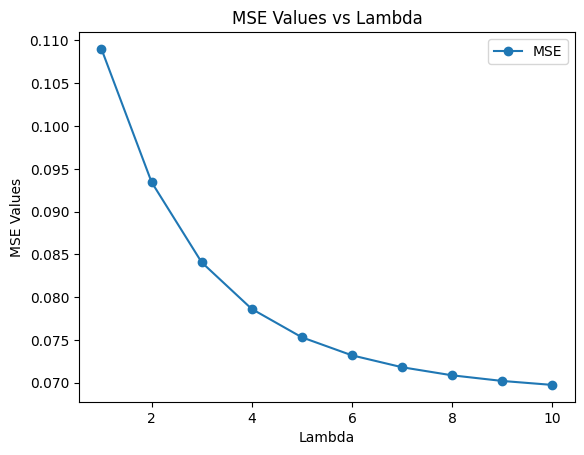

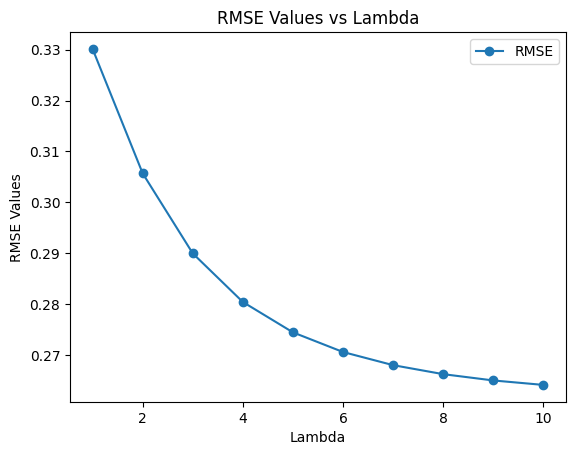

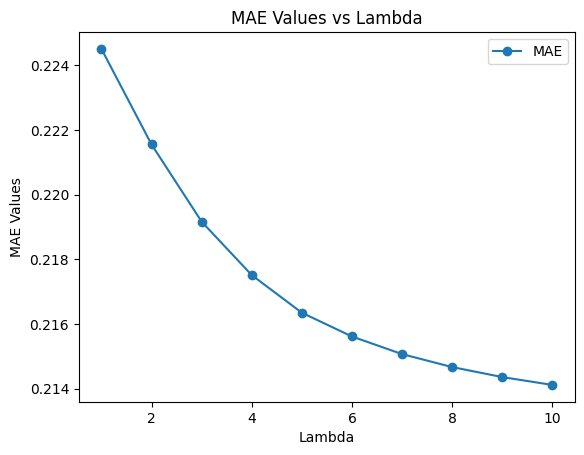

In [ ]:
# Plotting MSE for Ridge Regression
plt.plot(lambda_values, mse_rr_values, label='MSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting RMSE for Ridge Regression
plt.plot(lambda_values, r_mse_rr_values, label='RMSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting MAE for Ridge Regression
plt.plot(lambda_values, mae_rr_values, label='MAE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MAE Values')
plt.title('MAE Values vs Lambda')
plt.legend()
plt.show()


##### K-Nearest Neighbours Regression

In [ ]:
#HC

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mse_NN_values = []
r_mse_NN_values = []
mae_NN_values = []

for i in k_values:
    NN_predictions = Nearest_Neighbors(x_train, y_train, x_val, y_val, i)

    mse_NN, r_mse_NN, mae_NN = compute_metrics(y_val, NN_predictions)

    mse_NN_values.append(mse_NN)
    r_mse_NN_values.append(r_mse_NN)
    mae_NN_values.append(mae_NN)

    print("Mean Squared Error for k = ", i, ": ", mse_NN)
    print("Root Mean Squared Error for k = ", i, ": ", r_mse_NN)
    print("Mean Absolute Error for k = ", i, ": ", mae_NN)
    print("")

Mean Squared Error for k =  1 :  0.16149647887323926
Root Mean Squared Error for k =  1 :  0.4018662450035326
Mean Absolute Error for k =  1 :  0.3080985915492956

Mean Squared Error for k =  2 :  0.12125880281690134
Root Mean Squared Error for k =  2 :  0.34822234680861786
Mean Absolute Error for k =  2 :  0.2679577464788734

Mean Squared Error for k =  3 :  0.11028755868544612
Root Mean Squared Error for k =  3 :  0.3320957071168583
Mean Absolute Error for k =  3 :  0.25363849765258245

Mean Squared Error for k =  4 :  0.10854423415492943
Root Mean Squared Error for k =  4 :  0.32946051987291197
Mean Absolute Error for k =  4 :  0.24885563380281694

Mean Squared Error for k =  5 :  0.09856690140845048
Root Mean Squared Error for k =  5 :  0.31395366124390156
Mean Absolute Error for k =  5 :  0.23556338028169027

Mean Squared Error for k =  6 :  0.09801251956181505
Root Mean Squared Error for k =  6 :  0.31306951234800084
Mean Absolute Error for k =  6 :  0.23180751173708933

Mean Squ

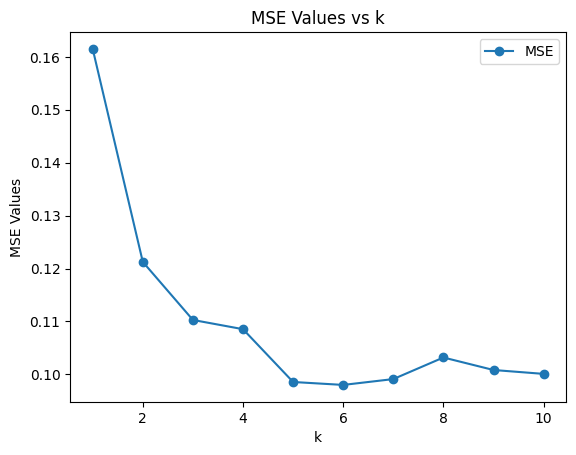

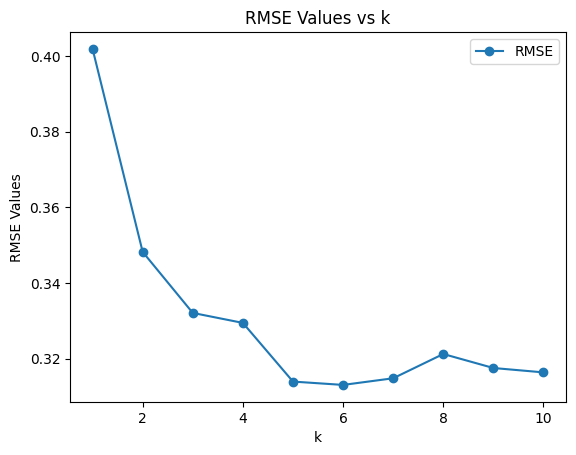

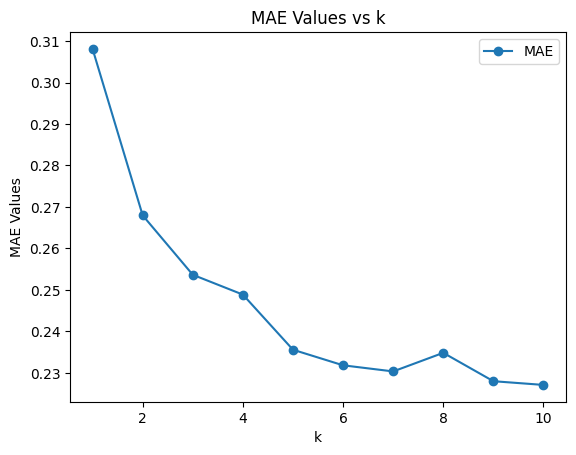

In [ ]:
# Plotting MSE for NN
plt.plot(k_values, mse_NN_values, label='MSE', marker='o')
plt.xlabel('k')
plt.ylabel('MSE Values')
plt.title('MSE Values vs k')
plt.legend()
plt.show()

# Plotting RMSE for NN
plt.plot(k_values, r_mse_NN_values, label='RMSE', marker='o')
plt.xlabel('k')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs k')
plt.legend()
plt.show()

# Plotting MAE for NN
plt.plot(k_values, mae_NN_values, label='MAE', marker='o')
plt.xlabel('k')
plt.ylabel('MAE Values')
plt.title('MAE Values vs k')
plt.legend()
plt.show()


##### MSE Regression

##### Support Vector Regression (SVR)

In [ ]:
#RH

def svr(train_data, train_label, val_data, val_label, kernel_type, C_value, epsilon_value):
    svr_model = SVR(kernel = kernel_type, C = C_value, epsilon = epsilon_value)

    svr_model.fit(train_data, train_label)

    svr_pred = svr_model.predict(val_data)

    return svr_pred




In [ ]:
kernel_types = ['rbf', 'linear', 'poly', 'sigmoid']

C = 0.1
epsilon = 0.01

# C_values = [0.1, 1, 5, 10]
# epsilon_values = [0.01, 0.1, 0.5, 1]

mse_svr_values = []
r_mse_svr_values = []
mae_svr_values = []

for i in kernel_types:
    svr_predictions = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), i, C, epsilon)

    mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

    print("Mean Squared Error for", i, "Kernel:", mse_svr)
    print("Root Mean Squared Error for", i, "Kernel:", r_mse_svr)
    print("Mean Absolute Error for", i, "Kernel:", mae_svr)
    print("")



# for i in kernel_types:
#     for j in C_values:
#         for k in epsilon_values:
#             svr_predictions = svr(x_train, y_train, x_val, y_val, i, j, k)

#             mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

#             mse_svr_values.append(mse_svr)
#             # r_mse_svr_values.append(r_mse_svr)
#             # mae_svr_values.append(mae_svr)

#             print("Mean Squared Error for Kernel Type: ", i, ", and Epsilon = ", k, ", and C = ", j, ": ", mse_svr)


Mean Squared Error for rbf Kernel: 0.1390420074155494
Root Mean Squared Error for rbf Kernel: 0.37288336972242325
Mean Absolute Error for rbf Kernel: 0.24349355919891316

Mean Squared Error for linear Kernel: 0.31964836117465967
Root Mean Squared Error for linear Kernel: 0.5653745317704536
Mean Absolute Error for linear Kernel: 0.25276457473802966

Mean Squared Error for poly Kernel: 0.1548474274085175
Root Mean Squared Error for poly Kernel: 0.3935065786089446
Mean Absolute Error for poly Kernel: 0.2543914261549937

Mean Squared Error for sigmoid Kernel: 0.21414570952059028
Root Mean Squared Error for sigmoid Kernel: 0.46275880274781406
Mean Absolute Error for sigmoid Kernel: 0.2961375325608821



In [ ]:
#we see that RBF Kernel has the lowest error 

# C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
C_values = [0.1,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
#epsilon = 0.01
mse_svr_C_values = []

for i in C_values:
    svr_predictions_C = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'rbf', i, epsilon)

    mse_svr_C, r_mse_svr_C, mae_svr_C = compute_metrics(y_val, svr_predictions_C)

    mse_svr_C_values.append(mse_svr_C)

    print("Mean Squared Error for C =", i, ":", mse_svr_C)
    # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
    # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
    print("")

Mean Squared Error for C = 0.1 : 0.1390420074155494

Mean Squared Error for C = 1 : 0.07684952970600126

Mean Squared Error for C = 2 : 0.073036090000398

Mean Squared Error for C = 3 : 0.07225313819620392

Mean Squared Error for C = 4 : 0.0724428469675795

Mean Squared Error for C = 5 : 0.07237048843386362

Mean Squared Error for C = 6 : 0.07248932819106695

Mean Squared Error for C = 7 : 0.07281423298288002

Mean Squared Error for C = 8 : 0.07360717539497345

Mean Squared Error for C = 9 : 0.07470924312254065

Mean Squared Error for C = 10 : 0.07529444974349699

Mean Squared Error for C = 12 : 0.07616972197649907

Mean Squared Error for C = 14 : 0.07647238389781692

Mean Squared Error for C = 16 : 0.07708854838638968

Mean Squared Error for C = 18 : 0.07771040508280613

Mean Squared Error for C = 20 : 0.07832468964336485



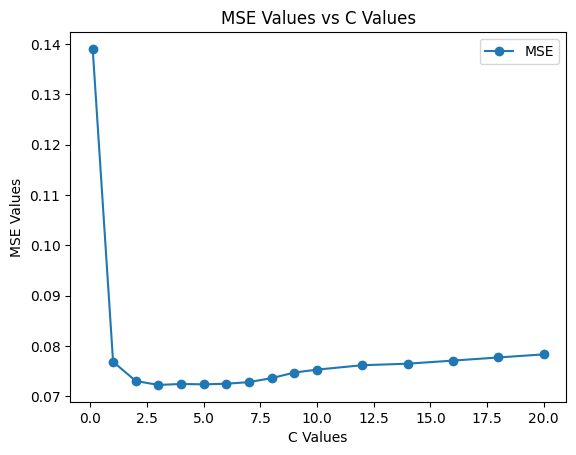

In [ ]:
# Plotting MSE for SVR a RBF Kernel: Epsilon = 0.01, C Changes
plt.plot(C_values, mse_svr_C_values, label='MSE', marker='o')
plt.xlabel('C Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs C Values')
plt.legend()
plt.show()

In [ ]:
#Lower values of C gives the best MSE

epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]
C = 0.1
mse_svr_epsilon_values = []


for i in epsilon_values:
    svr_predictions_E = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'rbf', C, i)

    mse_svr_E, r_mse_svr_E, mae_svr_E = compute_metrics(y_val, svr_predictions_E)

    mse_svr_epsilon_values.append(mse_svr_E)

    print("Mean Squared Error for Epsilon =", i, ":", mse_svr_E)
    # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
    # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
    print("")

Mean Squared Error for Epsilon = 0.001 : 0.1387246918932867

Mean Squared Error for Epsilon = 0.01 : 0.1390420074155494

Mean Squared Error for Epsilon = 0.1 : 0.14060728964617183

Mean Squared Error for Epsilon = 0.2 : 0.1409302770643603

Mean Squared Error for Epsilon = 0.5 : 0.15347274343749293

Mean Squared Error for Epsilon = 1 : 0.2452555433976956

Mean Squared Error for Epsilon = 2 : 0.7148543664897787

Mean Squared Error for Epsilon = 5 : 1.087623239436615

Mean Squared Error for Epsilon = 10 : 1.087623239436615



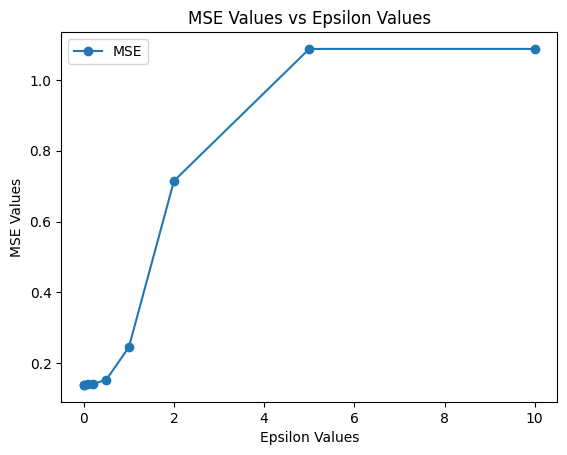

In [ ]:
# Plotting MSE for SVR a RBF Kernel: C = 0.1, Epsilon Changes
plt.plot(epsilon_values, mse_svr_epsilon_values, label='MSE', marker='o')
plt.xlabel('Epsilon Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Epsilon Values')
plt.legend()
plt.show()

#### Out-of-Class Models

##### Random Forest

In [ ]:
#RH

def random_forest(num_trees, train_data, train_label, val_data, val_label):
    random_forest_model = RandomForestRegressor(n_estimators = num_trees, random_state = 42)
    random_forest_model.fit(train_data, train_label)
    predictions = random_forest_model.predict(val_data)

    return predictions


In [ ]:
num_tree_values = [10, 50, 100, 250]

for i in num_tree_values:
    rf_predictions = random_forest(i, x_train, y_train.ravel(), x_val, y_val.ravel())
    mse_rf, r_mse_rf, mae_rf = compute_metrics(y_val, rf_predictions)


    print(f"Number of Random Forests: {i} \n")
    print("Mean Squared Error: ", mse_rf)
    print("Root Mean Squared Error: ", r_mse_rf)
    print("Mean Absolute Error :", mae_rf)
    print("")

Number of Random Forests: 10 

Mean Squared Error:  0.07773732394366219
Root Mean Squared Error:  0.2788141387083198
Mean Absolute Error : 0.21197183098591565

Number of Random Forests: 50 

Mean Squared Error:  0.07037792253521064
Root Mean Squared Error:  0.26528837617809536
Mean Absolute Error : 0.2006408450704213

Number of Random Forests: 100 

Mean Squared Error:  0.07054059507042108
Root Mean Squared Error:  0.26559479488578286
Mean Absolute Error : 0.20016901408450508

Number of Random Forests: 250 

Mean Squared Error:  0.06986494760563193
Root Mean Squared Error:  0.2643197828495475
Mean Absolute Error : 0.1975239436619706



##### Gradient Boosting

In [ ]:
#HC

##### Long Short Term Memory Neural Network (LSTM)

In [ ]:
#HC

### Results

In [ ]:
### 
#here we compare all the mse results from all the models, and then pick the model that has the best mse, rmse etc. metrics

### Final Predictions on Test Set

In [ ]:
# train that model we select from above on the entire training set, and then validate it on the test

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=498fdfc4-75bb-4c68-a720-cea81bc987b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>